In [ ]:
# Imports
import os
import requests
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, model_selection
from tempfile import TemporaryDirectory
import seaborn as sns
import time
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.models import resnet18
import numpy as np
import pandas as pd
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device:", DEVICE.upper())

# manual random seed is used for dataset partitioning
# to ensure reproducible results across runs
RNG = torch.Generator().manual_seed(1991)
torch.manual_seed(1991)
torch.cuda.manual_seed(1991)

import random
random.seed(1991)

import numpy as np
np.random.seed(1991)

Running on device: CUDA


In [ ]:
# CIFAR 10 dataset
torch.manual_seed(1991)
# Transformations
normalize = transforms.Compose(
    [
         transforms.RandomRotation(30), # Randomly rotate some images by 20 degrees
         transforms.RandomHorizontalFlip(), # Randomly horizontal flip the images
         transforms.ColorJitter(brightness = 0.1, # Randomly adjust color jitter of the images
                                                            contrast = 0.1,
                                                            saturation = 0.1),
         transforms.RandomAdjustSharpness(sharpness_factor = 2,
                                                                      p = 0.1), # Randomly adjust sharpness
          transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.
        transforms.ToTensor(),
    ]
)

to_tensor_transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)


# Train data
train_set = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=normalize
)
# Train loader
train_loader = DataLoader(train_set, batch_size=256, shuffle=True, num_workers=2)

# Test data
test_set = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=to_tensor_transform
)
# Test loader
test_loader = DataLoader(test_set, batch_size=256, shuffle=True, num_workers=2)

100%|██████████| 170498071/170498071 [00:02<00:00, 72880596.81it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


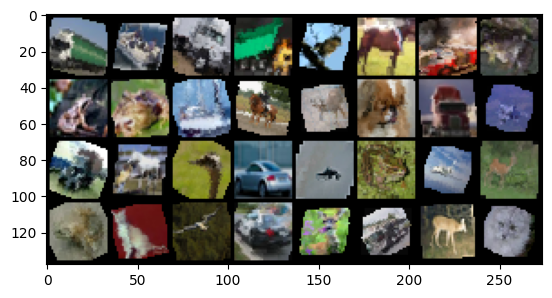

In [ ]:

# Display train images

# Create helper loader
# Train loader
torch.manual_seed(1991)
train_images_display_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=2)

batch_generator = enumerate(train_images_display_loader)
i, batch = next(batch_generator, 0)

grid_img = torchvision.utils.make_grid(batch[0], nrow=8)
plt.imshow(grid_img.permute(1, 2, 0))

In [ ]:

# Add helping dicts
dataloaders = {
    "train": train_loader,
    "val": test_loader
}

dataset_sizes = {"train": len(train_set), "val": len(test_set)}


In [ ]:

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    torch.manual_seed(1991)
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_loss = 1000

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(DEVICE)
                    labels = labels.to(DEVICE)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train' and scheduler:
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_loss < best_loss:
                    best_loss = epoch_loss
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val loss: {best_loss:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model


In [ ]:

# Train ResNet18
torch.manual_seed(1991)
model_train_with_aug = resnet18(weights=None, num_classes=10) # Load resnet18 from pytorch
model_train_with_aug = model_train_with_aug.to(DEVICE)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_train_with_aug.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=12, gamma=0.001)

In [ ]:
# Train model Resnet18 21 epochs
model_train_with_aug = train_model(model_train_with_aug, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=30)

Epoch 0/29
----------
train Loss: 1.6023 Acc: 0.4207
val Loss: 1.2940 Acc: 0.5346

Epoch 1/29
----------
train Loss: 1.3165 Acc: 0.5283
val Loss: 1.1256 Acc: 0.5903

Epoch 2/29
----------
train Loss: 1.2003 Acc: 0.5721
val Loss: 1.1116 Acc: 0.6098

Epoch 3/29
----------
train Loss: 1.1099 Acc: 0.6064
val Loss: 1.1362 Acc: 0.5999

Epoch 4/29
----------
train Loss: 1.0522 Acc: 0.6242
val Loss: 1.0449 Acc: 0.6250

Epoch 5/29
----------
train Loss: 0.9964 Acc: 0.6489
val Loss: 0.9456 Acc: 0.6676

Epoch 6/29
----------
train Loss: 0.9518 Acc: 0.6654
val Loss: 0.9202 Acc: 0.6725

Epoch 7/29
----------
train Loss: 0.9164 Acc: 0.6758
val Loss: 0.9262 Acc: 0.6741

Epoch 8/29
----------
train Loss: 0.8775 Acc: 0.6895
val Loss: 0.9100 Acc: 0.6803

Epoch 9/29
----------
train Loss: 0.8514 Acc: 0.7000
val Loss: 0.9253 Acc: 0.6774

Epoch 10/29
----------
train Loss: 0.8237 Acc: 0.7111
val Loss: 0.8943 Acc: 0.6942

Epoch 11/29
----------
train Loss: 0.7954 Acc: 0.7196
val Loss: 0.8354 Acc: 0.7193

Ep

In [ ]:
# Train data
train_set = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=to_tensor_transform
)
# Train loader
train_loader = DataLoader(train_set, batch_size=256, shuffle=True, num_workers=2)

Files already downloaded and verified


In [ ]:
torch.save(model_train_with_aug.state_dict(), "cifar10_resnet18_augmentation.pt")

In [ ]:
model_train_with_aug.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Check accuracy

def accuracy(net, loader):
    """Return accuracy on a dataset given by the data loader."""
    correct = 0
    total = 0
    for i, (inputs, targets) in enumerate(loader, 0):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        outputs = net(inputs)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    return correct / total


print(f"Train set accuracy: {100.0 * accuracy(model_train_with_aug, train_loader):0.1f}%")
print(f"Test set accuracy: {100.0 * accuracy(model_train_with_aug, test_loader):0.1f}%")

Train set accuracy: 81.8%
Test set accuracy: 77.0%


In [ ]:
df_dict = {
    "label": [],
    "last_conv_layer": [],
    "train": [],
    "loss": []
}

In [ ]:
total_num = 0
criterion = nn.CrossEntropyLoss(reduction="none")
for i, batch in enumerate(train_loader, 0):
  images, labels = batch
  images = images.to(DEVICE)
  for image, label in zip(images, labels):
    logits = model_train_with_aug(image.unsqueeze(0))
    total_num += 1
    losses = criterion(logits, label.unsqueeze(0).to(DEVICE)).numpy(force=True)

    df_dict["loss"].append(losses[0])
    df_dict["label"].append(label)
    df_dict["train"].append("Тренувальний набір")
    if total_num >= 10000:
      break
  if total_num >= 10000:
    break



In [ ]:
total_num = 0
for i, batch in enumerate(test_loader, 0):
  images, labels = batch
  images = images.to(DEVICE)
  for image, label in zip(images, labels):
    logits = model_train_with_aug(image.unsqueeze(0))
    total_num += 1
    losses = criterion(logits, label.unsqueeze(0).to(DEVICE)).numpy(force=True)

    df_dict["loss"].append(losses[0])
    df_dict["label"].append(label)
    df_dict["train"].append("Тестовий набір")

In [ ]:


df = pd.DataFrame.from_dict({
    "train": df_dict["train"],
    "loss": df_dict["loss"]
})


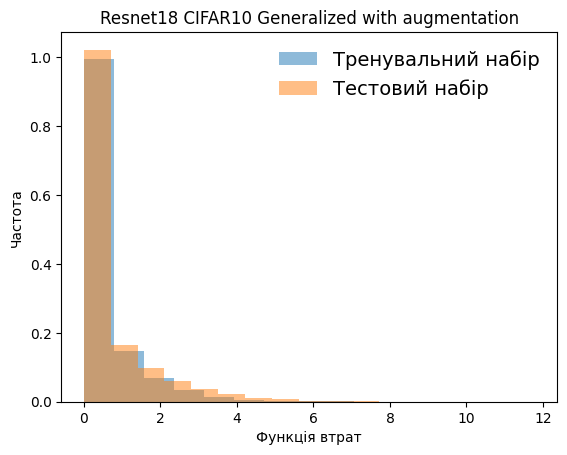

In [ ]:

plt.title(f"Resnet18 CIFAR10 Generalized with augmentation")
plt.hist(df.loc[df["train"] == "Тренувальний набір"]["loss"], density=True, alpha=0.5, bins=15, label="Тренувальний набір")
plt.hist(df.loc[df["train"] == "Тестовий набір"]["loss"], density=True, alpha=0.5, bins=15, label="Тестовий набір")

plt.ylabel("Частота")
plt.xlabel("Функція втрат")
plt.legend(frameon=False, fontsize=14)
plt.show()

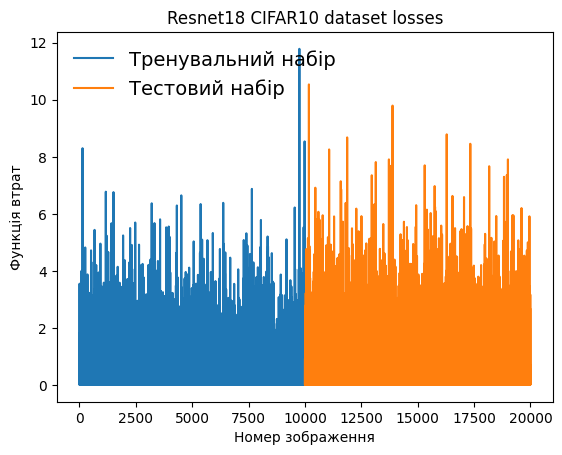

In [ ]:

plt.title(f"Resnet18 CIFAR10 dataset losses")
plt.plot(df.loc[df["train"] == "Тренувальний набір"]["loss"], label="Тренувальний набір")
plt.plot(df.loc[df["train"] == "Тестовий набір"]["loss"], label="Тестовий набір")

plt.ylabel("Функція втрат")
plt.xlabel("Номер зображення")
plt.legend(frameon=False, fontsize=14)
plt.show()
